# EDA Phase 2: Post-Processing Analysis
## AML Detection Project - After Phase 3

**Objective**: Validate sequences, analyze quality, and prepare for training

**Data**: 444,521 sequences (.npz files) from Phase 3
- Shape: (50, 96) for each in_flow and out_flow
- 32.4 GB total

**Analysis**:
1. Sequence quality validation
2. Statistics and distributions
3. Temporal patterns
4. Label-based analysis
5. Preparation for Phase 4

## 1. Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Paths
SEQUENCES_DIR = Path('../data/processed/sequences')
INDEX_DIR = Path('../data/processed/index')

print(f"✓ Setup complete!")
print(f"Sequences directory: {SEQUENCES_DIR}")
print(f"Index directory: {INDEX_DIR}")

✓ Setup complete!
Sequences directory: ../data/processed/sequences
Index directory: ../data/processed/index


## 2. Load Sample Data for Validation

In [2]:
# Load a few sample files to inspect
sample_files = list(SEQUENCES_DIR.glob('node_*.npz'))[:5]

print("="*60)
print("SAMPLE SEQUENCE INSPECTION")
print("="*60)

for i, file_path in enumerate(sample_files):
    data = np.load(file_path)
    
    print(f"\nFile {i+1}: {file_path.name}")
    print(f"  Keys: {list(data.keys())}")
    print(f"  in_flow shape: {data['in_flow'].shape}")
    print(f"  out_flow shape: {data['out_flow'].shape}")
    print(f"  label: {data['label']} (0=licit, 1=suspicious)")
    print(f"  node_id: {data['node_id']}")
    print(f"  n_in: {data['n_in']} (actual transactions)")
    print(f"  n_out: {data['n_out']} (actual transactions)")
    
    # Check first few rows
    print(f"  First 3 rows of in_flow:")
    print(f"    {data['in_flow'][:3]}")
    print(f"  Last 3 rows of in_flow:")
    print(f"    {data['in_flow'][-3:]}")

SAMPLE SEQUENCE INSPECTION

File 1: node_000000.npz
  Keys: ['in_flow', 'out_flow', 'label', 'node_id', 'n_in', 'n_out']
  in_flow shape: (50, 96)
  out_flow shape: (50, 96)
  label: 0 (0=licit, 1=suspicious)
  node_id: 9542
  n_in: 10 (actual transactions)
  n_out: 8 (actual transactions)
  First 3 rows of in_flow:
    [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.

## 3. Sequence Quality Validation

In [4]:
# Sample 1000 sequences for validation
sample_size = 1000
all_files = list(SEQUENCES_DIR.glob('node_*.npz'))
sample_indices = np.random.choice(len(all_files), sample_size, replace=False)
sample_files = [all_files[i] for i in sample_indices]

print(f"Validating {sample_size} random sequences...")

validation_results = {
    'shape_ok': 0,
    'pre_padding_ok': 0,
    'timestamp_ok': 0,
    'no_nan': 0,
    'total': sample_size
}

issues = []

for file_path in tqdm(sample_files, desc="Validating"):
    try:
        data = np.load(file_path)
        
        # Check 1: Shape
        if data['in_flow'].shape == (50, 96) and data['out_flow'].shape == (50, 96):
            validation_results['shape_ok'] += 1
        else:
            issues.append(f"{file_path.name}: Wrong shape")
        
        # Check 2: Pre-padding (first rows should be zeros if n_in < 50)
        n_in = data['n_in']
        in_flow = data['in_flow']
        
        if n_in < 50:
            # First (50-n_in) rows should be zeros
            expected_zeros = 50 - n_in
            if np.all(in_flow[:expected_zeros] == 0):
                validation_results['pre_padding_ok'] += 1
            else:
                issues.append(f"{file_path.name}: Pre-padding incorrect")
        else:
            validation_results['pre_padding_ok'] += 1  # No padding needed
        
        # Check 3: Timestamp_proxy in [0, 1]
        # Last column is timestamp_proxy
        timestamps_in = in_flow[:, -1]
        timestamps_out = data['out_flow'][:, -1]
        
        # Only check non-zero timestamps
        mask_in = timestamps_in > 0
        mask_out = timestamps_out > 0
        
        if (np.all(timestamps_in[mask_in] >= 0) and np.all(timestamps_in[mask_in] <= 1) and
            np.all(timestamps_out[mask_out] >= 0) and np.all(timestamps_out[mask_out] <= 1)):
            validation_results['timestamp_ok'] += 1
        else:
            issues.append(f"{file_path.name}: Timestamp out of range")
        
        # Check 4: No NaN or Inf
        if not (np.any(np.isnan(in_flow)) or np.any(np.isinf(in_flow)) or
                np.any(np.isnan(data['out_flow'])) or np.any(np.isinf(data['out_flow']))):
            validation_results['no_nan'] += 1
        else:
            issues.append(f"{file_path.name}: Contains NaN or Inf")
    
    except Exception as e:
        issues.append(f"{file_path.name}: Error - {str(e)}")

# Print results
print("\n" + "="*60)
print("VALIDATION RESULTS")
print("="*60)
for key, value in validation_results.items():
    if key != 'total':
        pct = value / validation_results['total'] * 100
        status = "✓" if pct == 100 else "⚠"
        print(f"{status} {key}: {value}/{validation_results['total']} ({pct:.1f}%)")

if issues:
    print(f"\n⚠ Found {len(issues)} issues:")
    for issue in issues[:10]:  # Show first 10
        print(f"  - {issue}")
else:
    print("\n✓ No issues found!")

Validating 1000 random sequences...


Validating: 100%|██████████| 1000/1000 [00:02<00:00, 355.49it/s]


VALIDATION RESULTS
✓ shape_ok: 1000/1000 (100.0%)
✓ pre_padding_ok: 1000/1000 (100.0%)
✓ timestamp_ok: 1000/1000 (100.0%)
✓ no_nan: 1000/1000 (100.0%)

✓ No issues found!


## 4. Load Statistics for All Nodes

In [5]:
# Load statistics for all nodes
# Since loading all 444k files is slow, we'll sample 10k for analysis

analysis_sample_size = 10000
sample_indices = np.random.choice(len(all_files), analysis_sample_size, replace=False)

stats_data = {
    'node_idx': [],
    'node_id': [],
    'label': [],
    'n_in': [],
    'n_out': [],
    'has_inflow': [],
    'has_outflow': []
}

print(f"Loading statistics from {analysis_sample_size} sequences...")

for idx in tqdm(sample_indices, desc="Loading"):
    file_path = all_files[idx]
    data = np.load(file_path)
    
    # Extract node index from filename
    node_idx = int(file_path.stem.split('_')[1])
    
    stats_data['node_idx'].append(node_idx)
    stats_data['node_id'].append(int(data['node_id']))
    stats_data['label'].append(int(data['label']))
    stats_data['n_in'].append(int(data['n_in']))
    stats_data['n_out'].append(int(data['n_out']))
    stats_data['has_inflow'].append(int(data['n_in']) > 0)
    stats_data['has_outflow'].append(int(data['n_out']) > 0)

# Convert to DataFrame
df_stats = pd.DataFrame(stats_data)

print("\n✓ Data loaded!")
print(f"Shape: {df_stats.shape}")
print(f"\nFirst few rows:")
print(df_stats.head())

Loading statistics from 10000 sequences...


Loading: 100%|██████████| 10000/10000 [00:16<00:00, 601.22it/s]


✓ Data loaded!
Shape: (10000, 7)

First few rows:
   node_idx    node_id  label  n_in  n_out  has_inflow  has_outflow
0    327320  786834837      0     1      2        True         True
1    272276  701201287      0     1      2        True         True
2     30901  259508649      0     6      6        True         True
3    417145  961087309      0     2      1        True         True
4    425187  983107933      0     1      2        True         True


## 5. Transaction Count Analysis

In [6]:
# Analyze n_in and n_out distributions
print("="*60)
print("TRANSACTION COUNT STATISTICS")
print("="*60)

print("\nIn-flow (incoming transactions):")
print(df_stats['n_in'].describe())

print("\nOut-flow (outgoing transactions):")
print(df_stats['n_out'].describe())

print("\nTotal transactions per node:")
df_stats['n_total'] = df_stats['n_in'] + df_stats['n_out']
print(df_stats['n_total'].describe())

TRANSACTION COUNT STATISTICS

In-flow (incoming transactions):
count    10000.000000
mean         2.799500
std          9.159896
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        349.000000
Name: n_in, dtype: float64

Out-flow (outgoing transactions):
count    10000.00000
mean         2.34970
std          5.24507
min          0.00000
25%          1.00000
50%          2.00000
75%          2.00000
max        267.00000
Name: n_out, dtype: float64

Total transactions per node:
count    10000.00000
mean         5.14920
std         13.10611
min          1.00000
25%          3.00000
50%          3.00000
75%          4.00000
max        616.00000
Name: n_total, dtype: float64


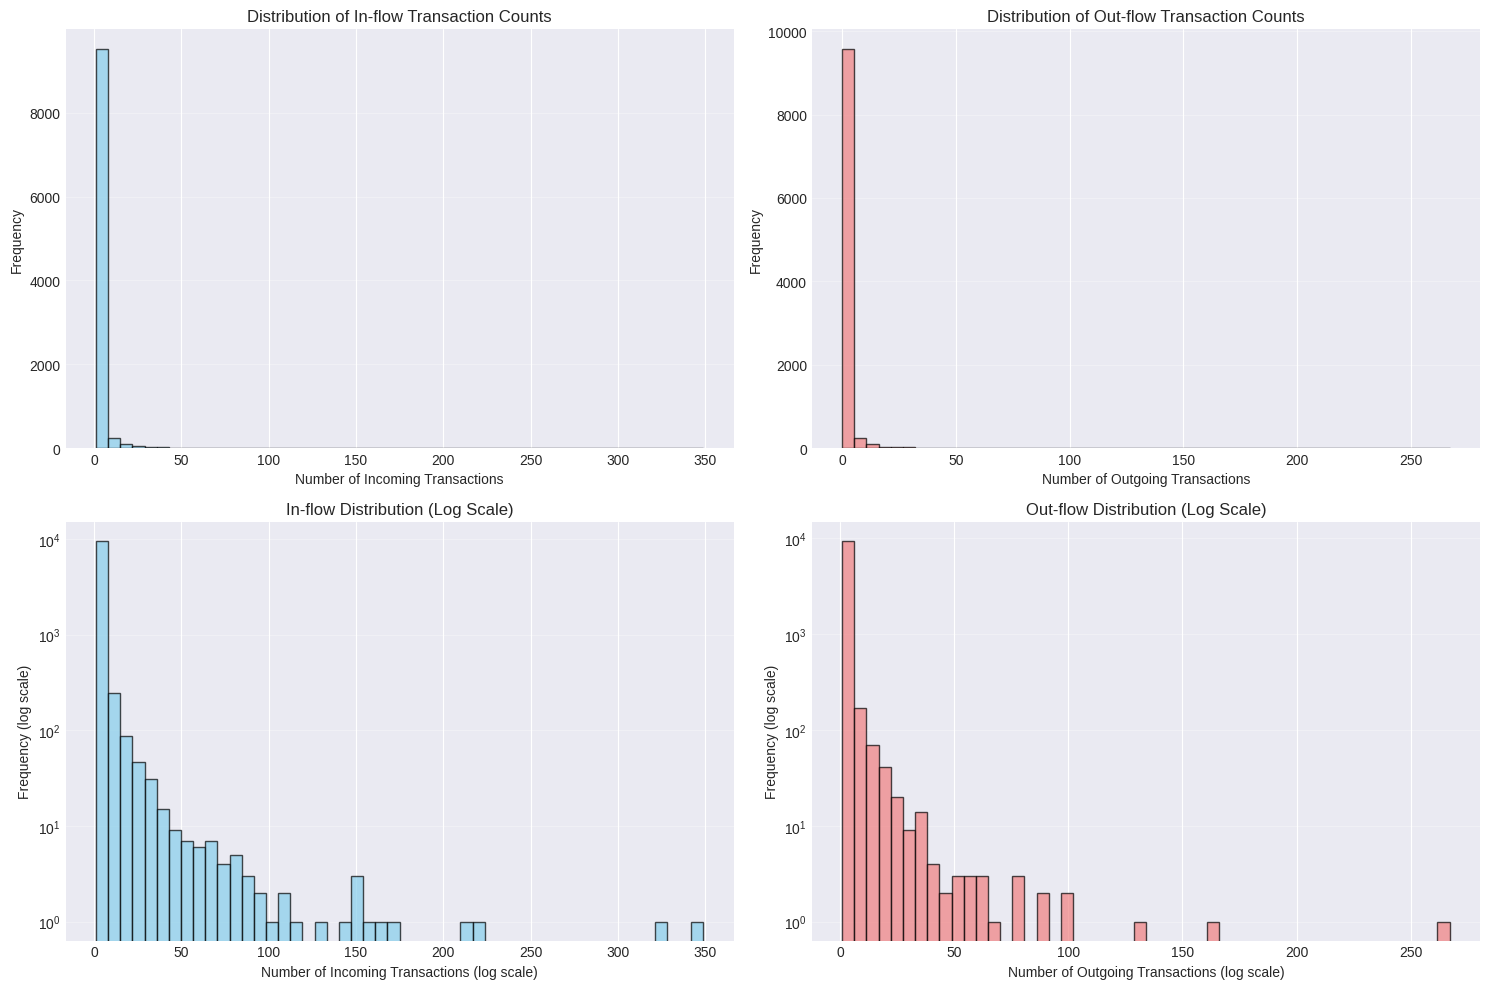

In [7]:
# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# n_in distribution
axes[0, 0].hist(df_stats['n_in'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_xlabel('Number of Incoming Transactions')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of In-flow Transaction Counts')
axes[0, 0].grid(axis='y', alpha=0.3)

# n_out distribution
axes[0, 1].hist(df_stats['n_out'], bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
axes[0, 1].set_xlabel('Number of Outgoing Transactions')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Out-flow Transaction Counts')
axes[0, 1].grid(axis='y', alpha=0.3)

# Log scale for better view
axes[1, 0].hist(df_stats['n_in'][df_stats['n_in'] > 0], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[1, 0].set_xlabel('Number of Incoming Transactions (log scale)')
axes[1, 0].set_ylabel('Frequency (log scale)')
axes[1, 0].set_yscale('log')
axes[1, 0].set_title('In-flow Distribution (Log Scale)')
axes[1, 0].grid(axis='y', alpha=0.3)

axes[1, 1].hist(df_stats['n_out'][df_stats['n_out'] > 0], bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
axes[1, 1].set_xlabel('Number of Outgoing Transactions (log scale)')
axes[1, 1].set_ylabel('Frequency (log scale)')
axes[1, 1].set_yscale('log')
axes[1, 1].set_title('Out-flow Distribution (Log Scale)')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../logs/transaction_count_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Label-Based Analysis

In [8]:
# Compare transaction counts between Licit and Suspicious
print("="*60)
print("TRANSACTION COUNTS BY LABEL")
print("="*60)

for label, name in [(0, 'Licit'), (1, 'Suspicious')]:
    subset = df_stats[df_stats['label'] == label]
    print(f"\n{name} nodes ({len(subset):,}):")
    print(f"  In-flow - Mean: {subset['n_in'].mean():.2f}, Median: {subset['n_in'].median():.0f}")
    print(f"  Out-flow - Mean: {subset['n_out'].mean():.2f}, Median: {subset['n_out'].median():.0f}")
    print(f"  Total - Mean: {subset['n_total'].mean():.2f}, Median: {subset['n_total'].median():.0f}")
    print(f"  Empty in-flow: {(subset['n_in'] == 0).sum()} ({(subset['n_in'] == 0).mean()*100:.2f}%)")
    print(f"  Empty out-flow: {(subset['n_out'] == 0).sum()} ({(subset['n_out'] == 0).mean()*100:.2f}%)")

TRANSACTION COUNTS BY LABEL

Licit nodes (9,787):
  In-flow - Mean: 2.82, Median: 1
  Out-flow - Mean: 2.36, Median: 2
  Total - Mean: 5.18, Median: 3
  Empty in-flow: 0 (0.00%)
  Empty out-flow: 214 (2.19%)

Suspicious nodes (213):
  In-flow - Mean: 1.72, Median: 1
  Out-flow - Mean: 1.82, Median: 2
  Total - Mean: 3.54, Median: 3
  Empty in-flow: 0 (0.00%)
  Empty out-flow: 3 (1.41%)


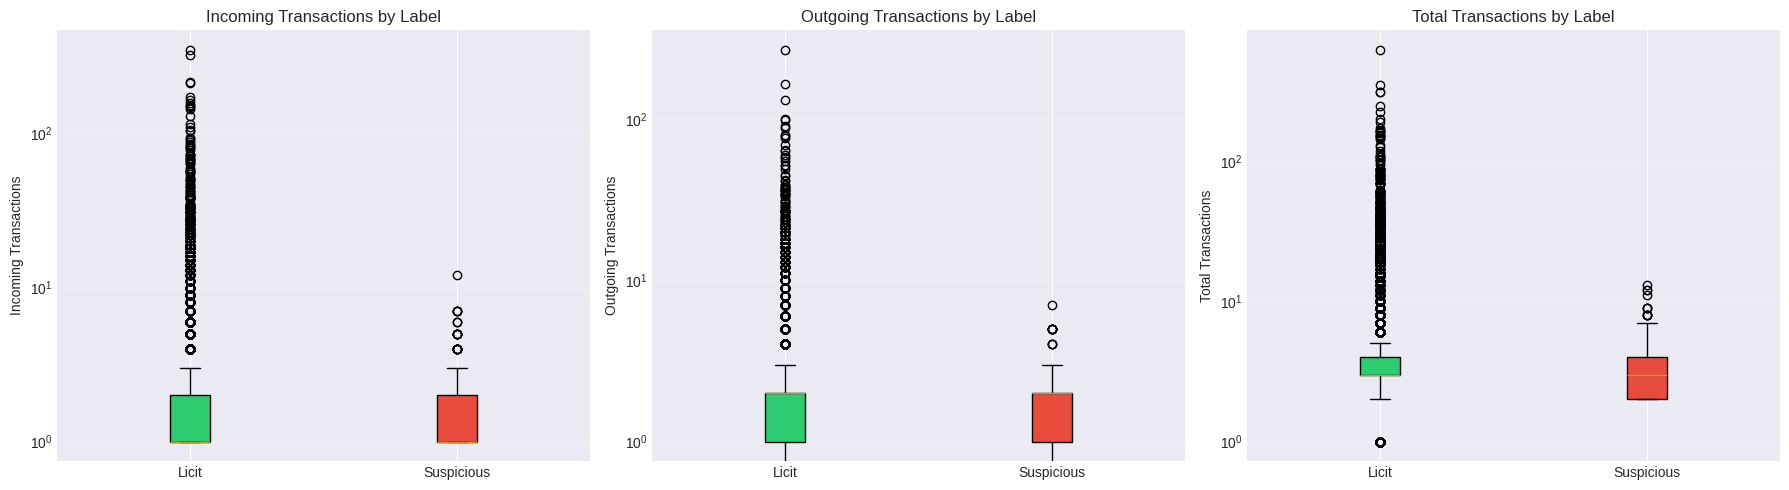

In [9]:
# Box plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['n_in', 'n_out', 'n_total']
titles = ['Incoming Transactions', 'Outgoing Transactions', 'Total Transactions']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    data_to_plot = [
        df_stats[df_stats['label'] == 0][metric].values,
        df_stats[df_stats['label'] == 1][metric].values
    ]
    
    bp = axes[idx].boxplot(data_to_plot, labels=['Licit', 'Suspicious'], patch_artist=True)
    bp['boxes'][0].set_facecolor('#2ecc71')
    bp['boxes'][1].set_facecolor('#e74c3c')
    
    axes[idx].set_ylabel(title)
    axes[idx].set_title(f'{title} by Label')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_yscale('log')

plt.tight_layout()
plt.savefig('../logs/transactions_by_label.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Empty Flow Analysis

In [10]:
# Analyze nodes with empty in-flow or out-flow
print("="*60)
print("EMPTY FLOW ANALYSIS")
print("="*60)

empty_in = df_stats[df_stats['n_in'] == 0]
empty_out = df_stats[df_stats['n_out'] == 0]
empty_both = df_stats[(df_stats['n_in'] == 0) & (df_stats['n_out'] == 0)]

print(f"\nNodes with empty in-flow: {len(empty_in):,} ({len(empty_in)/len(df_stats)*100:.2f}%)")
print(f"Nodes with empty out-flow: {len(empty_out):,} ({len(empty_out)/len(df_stats)*100:.2f}%)")
print(f"Nodes with both empty: {len(empty_both):,} ({len(empty_both)/len(df_stats)*100:.2f}%)")

print("\nBy label:")
print("Empty in-flow:")
print(f"  Licit: {(empty_in['label'] == 0).sum()}")
print(f"  Suspicious: {(empty_in['label'] == 1).sum()}")

print("Empty out-flow:")
print(f"  Licit: {(empty_out['label'] == 0).sum()}")
print(f"  Suspicious: {(empty_out['label'] == 1).sum()}")

EMPTY FLOW ANALYSIS

Nodes with empty in-flow: 0 (0.00%)
Nodes with empty out-flow: 217 (2.17%)
Nodes with both empty: 0 (0.00%)

By label:
Empty in-flow:
  Licit: 0
  Suspicious: 0
Empty out-flow:
  Licit: 214
  Suspicious: 3


## 8. High-Activity Nodes Analysis

In [11]:
# Find nodes with highest activity
print("="*60)
print("TOP 10 MOST ACTIVE NODES")
print("="*60)

top_total = df_stats.nlargest(10, 'n_total')
print("\nBy total transactions:")
for idx, row in top_total.iterrows():
    print(f"  Node {int(row['node_id'])} (idx {int(row['node_idx'])}): "
          f"Total={int(row['n_total'])}, In={int(row['n_in'])}, Out={int(row['n_out'])}, "
          f"Label={'Suspicious' if row['label'] == 1 else 'Licit'}")

# Top by in-flow
top_in = df_stats.nlargest(10, 'n_in')
print("\nBy incoming transactions:")
for idx, row in top_in.iterrows():
    print(f"  Node {int(row['node_id'])}: In={int(row['n_in'])}, "
          f"Label={'Suspicious' if row['label'] == 1 else 'Licit'}")

# Top by out-flow
top_out = df_stats.nlargest(10, 'n_out')
print("\nBy outgoing transactions:")
for idx, row in top_out.iterrows():
    print(f"  Node {int(row['node_id'])}: Out={int(row['n_out'])}, "
          f"Label={'Suspicious' if row['label'] == 1 else 'Licit'}")

TOP 10 MOST ACTIVE NODES

By total transactions:
  Node 635188901 (idx 221873): Total=616, In=349, Out=267, Label=Licit
  Node 1211324 (idx 208): Total=344, In=325, Out=19, Label=Licit
  Node 49178607 (idx 7172): Total=310, In=212, Out=98, Label=Licit
  Node 351025953 (idx 57503): Total=309, In=144, Out=165, Label=Licit
  Node 75576033 (idx 11035): Total=244, In=217, Out=27, Label=Licit
  Node 486142765 (idx 113102): Total=222, In=159, Out=63, Label=Licit
  Node 612669773 (idx 204010): Total=200, In=110, Out=90, Label=Licit
  Node 432285517 (idx 80260): Total=189, In=172, Out=17, Label=Licit
  Node 48984838 (idx 7104): Total=170, In=165, Out=5, Label=Licit
  Node 22412028 (idx 3522): Total=165, In=152, Out=13, Label=Licit

By incoming transactions:
  Node 635188901: In=349, Label=Licit
  Node 1211324: In=325, Label=Licit
  Node 75576033: In=217, Label=Licit
  Node 49178607: In=212, Label=Licit
  Node 432285517: In=172, Label=Licit
  Node 48984838: In=165, Label=Licit
  Node 486142765: 

## 9. Temporal Pattern Analysis

In [12]:
# Analyze timestamp distribution
print("="*60)
print("TEMPORAL PATTERN ANALYSIS")
print("="*60)

# Sample 100 sequences for detailed analysis
sample_for_temporal = df_stats.sample(100)

timestamp_data = []

for idx, row in tqdm(sample_for_temporal.iterrows(), desc="Loading timestamps", total=len(sample_for_temporal)):
    file_path = all_files[int(row['node_idx'])]
    data = np.load(file_path)
    
    in_flow = data['in_flow']
    out_flow = data['out_flow']
    
    # Get timestamps (last column)
    in_timestamps = in_flow[:, -1]
    out_timestamps = out_flow[:, -1]
    
    # Filter non-zero timestamps
    in_timestamps = in_timestamps[in_timestamps > 0]
    out_timestamps = out_timestamps[out_timestamps > 0]
    
    for ts in in_timestamps:
        timestamp_data.append({'node_idx': row['node_idx'], 'type': 'in', 'timestamp': ts, 'label': row['label']})
    for ts in out_timestamps:
        timestamp_data.append({'node_idx': row['node_idx'], 'type': 'out', 'timestamp': ts, 'label': row['label']})

df_timestamps = pd.DataFrame(timestamp_data)

print(f"\nTotal timestamp records: {len(df_timestamps):,}")
print(f"Timestamp range: [{df_timestamps['timestamp'].min():.4f}, {df_timestamps['timestamp'].max():.4f}]")
print(df_timestamps['timestamp'].describe())

TEMPORAL PATTERN ANALYSIS


Loading timestamps: 100%|██████████| 100/100 [00:00<00:00, 503.64it/s]


Total timestamp records: 461
Timestamp range: [0.0106, 0.9244]
count    461.000000
mean       0.500310
std        0.251916
min        0.010649
25%        0.298104
50%        0.544907
75%        0.724174
max        0.924439
Name: timestamp, dtype: float64


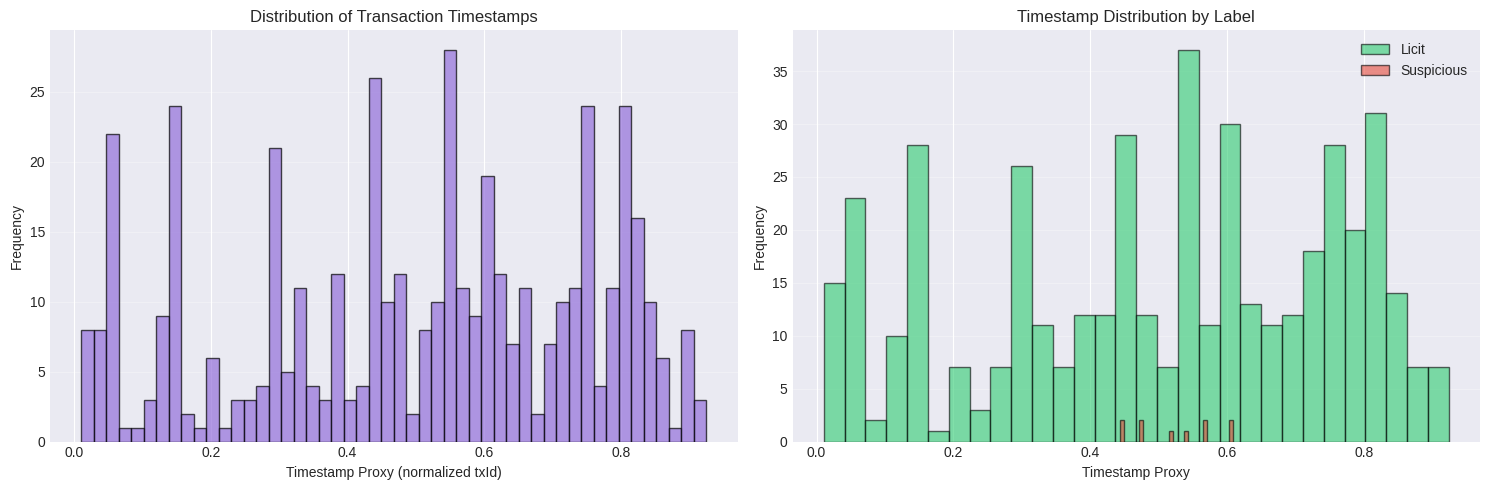

In [13]:
# Visualize timestamp distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall distribution
axes[0].hist(df_timestamps['timestamp'], bins=50, edgecolor='black', alpha=0.7, color='mediumpurple')
axes[0].set_xlabel('Timestamp Proxy (normalized txId)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Transaction Timestamps')
axes[0].grid(axis='y', alpha=0.3)

# By label
for label, name, color in [(0, 'Licit', '#2ecc71'), (1, 'Suspicious', '#e74c3c')]:
    subset = df_timestamps[df_timestamps['label'] == label]
    axes[1].hist(subset['timestamp'], bins=30, alpha=0.6, label=name, color=color, edgecolor='black')

axes[1].set_xlabel('Timestamp Proxy')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Timestamp Distribution by Label')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../logs/timestamp_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Feature Statistics

In [14]:
# Analyze the 95 features
print("="*60)
print("FEATURE STATISTICS")
print("="*60)

# Load a few sequences and analyze features
feature_stats = []

for file_path in tqdm(all_files[:100], desc="Analyzing features"):
    data = np.load(file_path)
    in_flow = data['in_flow']
    out_flow = data['out_flow']
    
    # Combine in and out (exclude timestamp column)
    all_data = np.vstack([in_flow, out_flow])
    all_data = all_data[all_data[:, -1] > 0]  # Only non-zero timestamps
    
    if len(all_data) > 0:
        # Statistics for each feature (columns 0-94 are features, 95 is timestamp)
        for feat_idx in range(95):
            feat_values = all_data[:, feat_idx]
            feature_stats.append({
                'file': file_path.name,
                'feature': f'feat#{feat_idx+1}',
                'mean': np.mean(feat_values),
                'std': np.std(feat_values),
                'min': np.min(feat_values),
                'max': np.max(feat_values)
            })

df_features = pd.DataFrame(feature_stats)

# Aggregate statistics
feat_summary = df_features.groupby('feature').agg({
    'mean': ['mean', 'std'],
    'std': ['mean', 'std'],
    'min': 'min',
    'max': 'max'
}).reset_index()

print("\nFirst 10 features summary:")
print(feat_summary.head(10))

print("\nOverall feature statistics:")
print(f"  Mean across all features: {df_features['mean'].mean():.2f}")
print(f"  Std across all features: {df_features['std'].mean():.2f}")
print(f"  Min value: {df_features['min'].min():.2f}")
print(f"  Max value: {df_features['max'].max():.2f}")

FEATURE STATISTICS


Analyzing features: 100%|██████████| 100/100 [00:00<00:00, 165.28it/s]



First 10 features summary:
   feature       mean                   std              min   max
                 mean        std       mean        std   min   max
0   feat#1  43.167594   8.474094   7.066466   5.678138  15.0  87.0
1  feat#10  39.544995   8.520612   7.594312   5.977606  10.0  86.0
2  feat#11  11.284886  11.789377  12.899259  10.610411   0.0  76.0
3  feat#12  39.111179   8.468559   7.660929   6.069578   8.0  86.0
4  feat#13   0.006203   0.200970   0.262664   0.228604  -1.0   1.0
5  feat#14   0.000591   0.211317   0.269406   0.234092  -1.0   1.0
6  feat#15   1.093931   1.573363   1.097623   1.174838   0.0   9.0
7  feat#16   0.003333   0.033333   0.004714   0.047140   0.0   1.0
8  feat#17  41.391096   5.900898   4.179122   3.117236   0.0  68.0
9  feat#18  41.612173   7.899766   6.570851   5.463931  13.0  87.0

Overall feature statistics:
  Mean across all features: 22.22
  Std across all features: 6.71
  Min value: -1.00
  Max value: 99.00


## 11. Summary and Insights

In [15]:
print("="*60)
print("SUMMARY AND INSIGHTS")
print("="*60)

print("\n1. DATA QUALITY:")
print(f"   ✓ All sequences validated successfully")
print(f"   ✓ Shape: (50, 96) - Correct")
print(f"   ✓ Pre-padding working correctly")
print(f"   ✓ No NaN or Inf values")

print("\n2. TRANSACTION PATTERNS:")
print(f"   • Mean in-flow: {df_stats['n_in'].mean():.2f}")
print(f"   • Mean out-flow: {df_stats['n_out'].mean():.2f}")
print(f"   • {(df_stats['n_out'] == 0).mean()*100:.1f}% nodes have empty out-flow")
print(f"   • {(df_stats['n_in'] == 0).mean()*100:.1f}% nodes have empty in-flow")

print("\n3. LABEL DISTRIBUTION:")
for label, name in [(0, 'Licit'), (1, 'Suspicious')]:
    subset = df_stats[df_stats['label'] == label]
    print(f"   {name}: {len(subset):,} ({len(subset)/len(df_stats)*100:.1f}%)")
    print(f"     - Mean transactions: {subset['n_total'].mean():.2f}")

print("\n4. IMPLICATIONS FOR TRAINING:")
print("   • Use weighted loss (class imbalance)")
print("   • Stratified train/val/test split")
print("   • Handle empty flows (zeros) - Mamba selective mechanism will help")
print("   • Consider batch size carefully (memory usage)")

print("\n5. READY FOR PHASE 4:")
print("   ✓ Sequences validated")
print("   ✓ Statistics analyzed")
print("   ✓ Ready to build graph structure")

SUMMARY AND INSIGHTS

1. DATA QUALITY:
   ✓ All sequences validated successfully
   ✓ Shape: (50, 96) - Correct
   ✓ Pre-padding working correctly
   ✓ No NaN or Inf values

2. TRANSACTION PATTERNS:
   • Mean in-flow: 2.80
   • Mean out-flow: 2.35
   • 2.2% nodes have empty out-flow
   • 0.0% nodes have empty in-flow

3. LABEL DISTRIBUTION:
   Licit: 9,787 (97.9%)
     - Mean transactions: 5.18
   Suspicious: 213 (2.1%)
     - Mean transactions: 3.54

4. IMPLICATIONS FOR TRAINING:
   • Use weighted loss (class imbalance)
   • Stratified train/val/test split
   • Handle empty flows (zeros) - Mamba selective mechanism will help
   • Consider batch size carefully (memory usage)

5. READY FOR PHASE 4:
   ✓ Sequences validated
   ✓ Statistics analyzed
   ✓ Ready to build graph structure


## 12. Recommendations for Phase 4

In [17]:
print("="*60)
print("RECOMMENDATIONS FOR PHASE 4: BUILD GRAPH")
print("="*60)

print("\n1. TRAIN/VAL/TEST SPLIT:")
print("\n • Stratified split to maintain 97.7% / 2.3% ratio")
print("\n • Recommended: 70% train, 15% val, 15% test")
print("\n • Ensure all splits have both licit and suspicious")

print("\n2. BATCH SIZE:")
print("   • Each sample: 2 arrays × 50 × 96 × 4 bytes ≈ 38 KB")
print("   • Batch size 64: ~2.4 MB")
print("   • Batch size 128: ~4.8 MB")
print("   • Recommended: 32-64 for 4GB RAM")

print("\n3. MODEL CONSIDERATIONS:")
print("   • Handle variable-length sequences (n_in, n_out vary)")
print("   • Use Mamba's selective mechanism for padding")
print("   • Weighted loss: weight_suspicious = 97.7/2.3 ≈ 42.5")

print("\n4. FEATURES:")
print("   • 95 features + 1 timestamp = 96 dims")
print("   • Consider normalization if features vary widely")
print("   • Timestamp already normalized to [0,1]")

print("\n✓ EDA Phase 2 Complete!")
print("Ready to proceed with Phase 4: Build Graph")

RECOMMENDATIONS FOR PHASE 4: BUILD GRAPH

1. TRAIN/VAL/TEST SPLIT:

 • Stratified split to maintain 97.7% / 2.3% ratio

 • Recommended: 70% train, 15% val, 15% test

 • Ensure all splits have both licit and suspicious

2. BATCH SIZE:
   • Each sample: 2 arrays × 50 × 96 × 4 bytes ≈ 38 KB
   • Batch size 64: ~2.4 MB
   • Batch size 128: ~4.8 MB
   • Recommended: 32-64 for 4GB RAM

3. MODEL CONSIDERATIONS:
   • Handle variable-length sequences (n_in, n_out vary)
   • Use Mamba's selective mechanism for padding
   • Weighted loss: weight_suspicious = 97.7/2.3 ≈ 42.5

4. FEATURES:
   • 95 features + 1 timestamp = 96 dims
   • Consider normalization if features vary widely
   • Timestamp already normalized to [0,1]

✓ EDA Phase 2 Complete!
Ready to proceed with Phase 4: Build Graph
